In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import cv2
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import PIL
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from pathlib import Path
import os.path
import random
import cv2
from tensorflow.keras.applications import InceptionV3

from PIL import Image, ImageChops, ImageEnhance
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard ,LearningRateScheduler
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.utils import class_weight
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization


In [2]:
# import each path of the image classes
glaucoma = Path('/content/drive/MyDrive/dataset/glaucoma')
cataract = Path('/content/drive/MyDrive/dataset/cataract')
normal = Path('/content/drive/MyDrive/dataset/normal')
diabetic_retinopathy = Path('/content/drive/MyDrive/dataset/diabetic_retinopathy')

In [3]:
# create a dataframe with the file path and the labels
disease_type = [glaucoma, cataract,normal,diabetic_retinopathy]
df = pd.DataFrame()
from tqdm import tqdm
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

/content/drive/MyDrive/dataset/normal: 100%|██████████| 1074/1074 [00:00<00:00, 1684.66it/s]
/content/drive/MyDrive/dataset/diabetic_retinopathy: 100%|██████████| 1098/1098 [00:00<00:00, 1703.64it/s]


In [4]:
df

,image,disease_type
0,/content/drive/MyDrive/dataset/glaucoma/1225_l...,0
1,/content/drive/MyDrive/dataset/glaucoma/1216_r...,0
2,/content/drive/MyDrive/dataset/glaucoma/1216_l...,0
3,/content/drive/MyDrive/dataset/glaucoma/1020_l...,0
4,/content/drive/MyDrive/dataset/glaucoma/1214_r...,0
...,...,...
4222,/content/drive/MyDrive/dataset/diabetic_retino...,3
4223,/content/drive/MyDrive/dataset/diabetic_retino...,3
4224,/content/drive/MyDrive/dataset/diabetic_retino...,3
4225,/content/drive/MyDrive/dataset/diabetic_retino...,3


In [5]:
# check the count of the target label
df.disease_type.value_counts()

3    1098
2    1074
1    1038
0    1017
Name: disease_type, dtype: int64

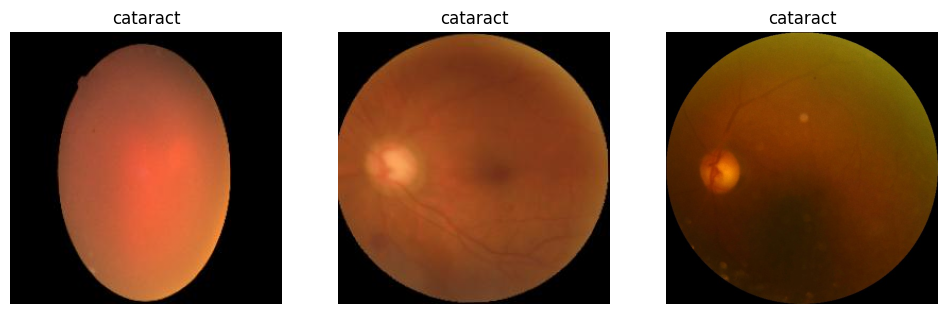

In [6]:
# define function to plot sample images
def plot_image(n, num_samples=3):
    disease_labels = ['glaucoma', 'cataract', 'normal', 'diabetic_retinopathy']
    images = df[df['disease_type'] == n].sample(num_samples)['image']

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n])

    plt.show()

plot_image(1)

In [7]:
# map the labels to the disease type
df['disease_type'] = df['disease_type'].map({0:'glaucoma',1:'cataract',2:'normal',3:'diabetic_retinopathy'})

In [8]:
df.disease_type.value_counts()

diabetic_retinopathy    1098
normal                  1074
cataract                1038
glaucoma                1017
Name: disease_type, dtype: int64

In [9]:
# randomising the dataset
df1 = df.sample(frac=1).reset_index(drop=True)

In [10]:
#import necessary libraries for the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

In [11]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)


In [12]:
# create the train data
train_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = True,
                                          subset = 'training')

Found 3382 validated image filenames belonging to 4 classes.


In [13]:
# create the validation data
valid_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = False,
                                          subset = 'validation')

Found 845 validated image filenames belonging to 4 classes.


In [14]:
def learning_rate_scheduler(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 5
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lr

In [15]:
# Define callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

In [16]:
train_labels = train_data.classes
class_weights = class_weight = dict(enumerate(len(train_data.classes) / (np.bincount(train_labels) * len(np.unique(train_labels)))))


In [17]:
labels=[key for key in train_data.class_indices]
num_classes = len(disease_type)

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

# Create the full model
model = models.Model(inputs=base_model.input, outputs=predictions)

model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [19]:
history = model.fit(
    train_data,
    steps_per_epoch=train_data.n // train_data.batch_size,
    epochs=20,
    validation_data=valid_data,
    validation_steps=valid_data.n // valid_data.batch_size,
    class_weight=class_weights,
    callbacks=[checkpoint, lr_scheduler]
)

Epoch 1/20
105/105 [==============================] - ETA: 0s - loss: 0.6710 - accuracy: 0.7490
Epoch 1: val_accuracy improved from -inf to 0.26923, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


105/105 [==============================] - 746s 7s/step - loss: 0.6710 - accuracy: 0.7490 - val_loss: 2436.9778 - val_accuracy: 0.2692 - lr: 0.0010
Epoch 2/20
105/105 [==============================] - ETA: 0s - loss: 0.5874 - accuracy: 0.8006
Epoch 2: val_accuracy improved from 0.26923 to 0.35096, saving model to best_model.h5
105/105 [==============================] - 45s 429ms/step - loss: 0.5874 - accuracy: 0.8006 - val_loss: 121.8553 - val_accuracy: 0.3510 - lr: 0.0010
Epoch 3/20
105/105 [==============================] - ETA: 0s - loss: 0.3924 - accuracy: 0.8594
Epoch 3: val_accuracy improved from 0.35096 to 0.81851, saving model to best_model.h5
105/105 [==============================] - 45s 429ms/step - loss: 0.3924 - accuracy: 0.8594 - val_loss: 0.6337 - val_accuracy: 0.8185 - lr: 0.0010
Epoch 4/20
105/105 [==============================] - ETA: 0s - loss: 0.3076 - accuracy: 0.8904
Epoch 4: val_accuracy improved from 0.81851 to 0.86659, saving model to best_model.h5
105/105 [=

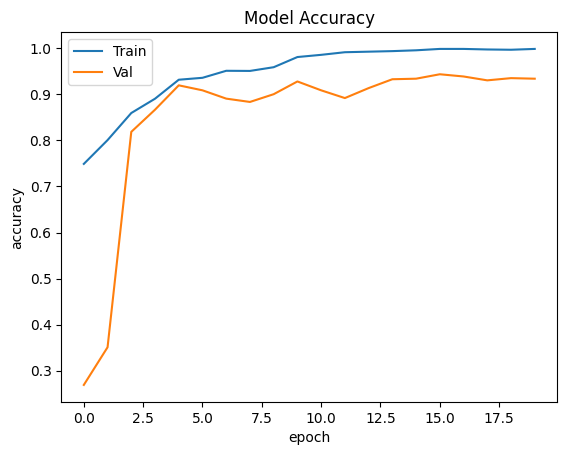

In [20]:
# create a plot of accuracy and val_acuracy for each epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

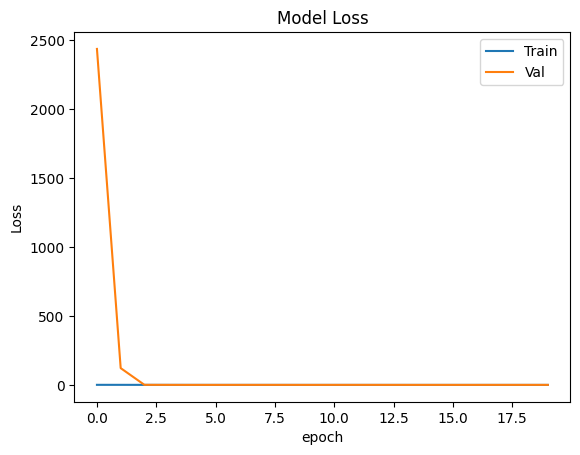

In [21]:
# create a plot of loss and val_loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

In [22]:
# evaluate the model
y_test = valid_data.classes
y_pred = model.predict(valid_data)
y_pred = np.argmax(y_pred,axis=1)

27/27 [==============================] - 9s 288ms/step


In [23]:


# generate classification report of the model
print(classification_report(y_test,y_pred,target_names = labels))

                      precision    recall  f1-score   support

            cataract       0.92      0.98      0.95       195
diabetic_retinopathy       1.00      1.00      1.00       228
            glaucoma       0.87      0.90      0.88       204
              normal       0.95      0.85      0.90       218

            accuracy                           0.93       845
           macro avg       0.93      0.93      0.93       845
        weighted avg       0.93      0.93      0.93       845



In [25]:
model.save("res_model.h5")

In [27]:

# load the model
from tensorflow.keras.models import load_model
inception_loadedmodel= load_model('/content/res_model.h5')

In [28]:
# create a function for prediction of image
def predict(img):
  y=image.img_to_array(img)
  y = np.expand_dims(y,axis = 0)
  pred =np.argmax(inception_loadedmodel.predict(y))
  op =['cataract','diabetic_retinopathy','glaucoma','normal']
  return op[pred]


In [31]:
from tensorflow.keras.preprocessing import image

In [33]:
img1 = image.load_img('/content/drive/MyDrive/dataset/diabetic_retinopathy/10042_right.jpeg',target_size =(224,224))
predict(img1)

1/1 [==============================] - 2s 2s/step


'diabetic_retinopathy'

In [35]:
img2 = image.load_img('/content/drive/MyDrive/dataset/normal/2329_left.jpg',target_size =(224,224))
predict(img2)

1/1 [==============================] - 0s 88ms/step


'cataract'

In [37]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from flask import Flask, render_template, request
import os
import numpy as np

app = Flask(__name__)
model = load_model("/content/res_model.h5", compile=False)




@app.route('/predict', methods=['GET','POST'])
def upload():
    if request.method == 'POST':
        f = request.files['image']
        basepath = os.path.dirname(__file__)
        filepath = os.path.join(basepath, 'uploads', f.filename)
        f.save(filepath)

        img = image.load_img(filepath, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        pred = np.argmax(model.predict(x), axis=1)
        index = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
        text = "The Eye Disease is  " + str(index[pred[0]])
        return text


if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [45]:
# Install necessary libraries
!pip install flask-ngrok
ngrok_auth_token = '2YaadNWZNaXXCDRCJ4CMNOc4kfR_7M7JBTDrXWnfiBpDETpNf'
# Import libraries
from flask import Flask

# Create a Flask app
app = Flask(__name__)
model = load_model("/content/res_model.h5", compile=False)
# Define a route
@app.route('/')
def upload():
    if request.method == 'POST':
        f = request.files['image']
        basepath = os.path.dirname(__file__)
        filepath = os.path.join(basepath, 'uploads', f.filename)
        f.save(filepath)

        img = image.load_img(filepath, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        pred = np.argmax(model.predict(x), axis=1)
        index = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
        text = "The Eye Disease is  " + str(index[pred[0]])
        return text

if __name__ == '__main__':
    # Use ngrok to tunnel the Flask app to a public URL
    from flask_ngrok import run_with_ngrok
    run_with_ngrok(app)

    # Start Flask app
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://9247-34-68-43-61.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


ERROR:__main__:Exception on / [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 2529, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1826, in full_dispatch_request
    return self.finalize_request(rv)
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1845, in finalize_request
    response = self.make_response(rv)
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 2138, in make_response
    raise TypeError(
TypeError: The view function for 'upload' did not return a valid response. The function either returned None or ended without a return statement.
INFO:werkzeug:127.0.0.1 - - [23/Nov/2023 19:20:37] "GET / HTTP/1.1" 500 -
ERROR:__main__:Exception on / [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 2529, in wsgi_app
    response = self.full_dispatch_request(

In [52]:
!pip uninstall ngrok
!pip install flask-ngrok


In [53]:

ngrok_auth_token = '2YaadNWZNaXXCDRCJ4CMNOc4kfR_7M7JBTDrXWnfiBpDETpNf'


In [54]:
# app.py
import os
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np

app = Flask(__name__)
run_with_ngrok(app)

# Load the pre-trained eye disease prediction model
model_path = '/content/res_model.h5'  # Replace with the actual path to your model
eye_model = load_model(model_path)

# Define a route to render the upload form
@app.route('/')
def upload_form():
    return render_template('upload.html')

# Define a route to handle image upload and make predictions
@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return "No file part"

    file = request.files['file']

    if file.filename == '':
        return "No selected file"

    if file:
        # Save the uploaded image to a temporary folder
        img_path = 'temp_image.jpg'
        file.save(img_path)

        # Preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make predictions
        predictions = eye_model.predict(img_array)

        # Perform any further processing based on your use case

        # Display the result or redirect to a new page
        result = f"Predictions: {predictions}"
        return result

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://bf33-34-68-43-61.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [23/Nov/2023 19:39:36] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Nov/2023 19:39:38] "GET /meta.json HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [23/Nov/2023 19:39:38] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [23/Nov/2023 19:39:38] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Nov/2023 19:39:38] "GET /meta.json HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [23/Nov/2023 19:39:38] "GET /meta.json HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [23/Nov/2023 19:40:38] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Nov/2023 19:40:39] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Nov/2023 19:40:39] "GET /meta.json HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [23/Nov/2023 19:40:39] "GET /meta.json HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [23/Nov/2023 19:40:39] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [23/Nov/2023 19:40:40] "GET /meta.json HTTP/1.1" 404 -
